In [28]:
import os
import cv2
import numpy as np
import random, tqdm
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import albumentations as album
from PIL import Image

In [2]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


NameError: name 'DATA_DIR' is not defined

In [48]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


In [4]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)


In [7]:
IMG_SIZE=512
# Satellite image augmentation pipeline
satellite_transform = album.Compose([
    # --- Geometric Augmentations ---
    # album.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
    album.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    album.HorizontalFlip(p=0.5),
    album.VerticalFlip(p=0.5),
    album.RandomRotate90(p=0.2),

    # --- Color and Brightness Adjustments ---
    album.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    album.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.2),
    album.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),

    # --- Blur / Noise ---
    album.OneOf([
        album.GaussianBlur(blur_limit=(3, 5), p=0.2),
        album.MedianBlur(blur_limit=3, p=0.2),
    ], p=0.3),

    # --- Other useful augmentations ---
    album.RandomGamma(gamma_limit=(80, 120), p=0.3),
    album.CLAHE(clip_limit=2.0, p=0.2),
])


In [8]:
def get_training_augmentation():
    return satellite_transform

def get_validation_augmentation():
    validation_transform = [
        album.CenterCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    ]
    return album.Compose(validation_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


In [21]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# # create segmentation model with pretrained encoder
# model = smp.DeepLabV3Plus(
#     encoder_name=ENCODER,
#     encoder_weights=ENCODER_WEIGHTS,
#     classes=len(CLASSES),
#     activation=ACTIVATION,
# )



In [22]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [10]:
pretrained_checkpoint_path = 'best_model_kaggle.pth'

In [11]:
model_kaggle = torch.load(pretrained_checkpoint_path, map_location='cpu')

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [13]:
def _to_multiple(x, k=32):
    return int(np.ceil(x / k) * k)

def _pad_to_multiple(img_np, k=32, mode="reflect"):
    """
    img_np: HxWxC (float32 or uint8)
    returns: padded_img, (top, left, h, w) crop info
    """
    H, W, C = img_np.shape
    Hn, Wn = _to_multiple(H, k), _to_multiple(W, k)
    pad_h, pad_w = Hn - H, Wn - W
    if pad_h == 0 and pad_w == 0:
        return img_np, (0, 0, H, W)

    # build padding (top, bottom, left, right)
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    if mode == "reflect":
        # reflect-pad manually
        def _reflect_pad(arr, top, bottom, left, right):
            arr = np.pad(arr, ((top, bottom), (left, right), (0, 0)), mode="reflect")
            return arr
        padded = _reflect_pad(img_np, top, bottom, left, right)
    else:
        padded = np.pad(img_np, ((top, bottom), (left, right), (0, 0)), mode="constant")

    # Save crop info to undo padding after prediction
    return padded, (top, left, H, W)

def _crop_from_pad(arr_chw, pad_info):
    """arr_chw: CxHxW -> crop back using (top, left, H, W)."""
    top, left, H, W = pad_info
    return arr_chw[:, top:top+H, left:left+W]


In [18]:
model_kaggle.to(DEVICE);

In [54]:
@torch.no_grad()
def test_folder(
    folder_path,
    model,
    preprocessing_fn,
    device="cuda" if torch.cuda.is_available() else "cpu",
    class_names=("urban_land", "agriculture_land", "forest_land"),
    show_soft=False,
    save_path=None,
):
    import matplotlib.pyplot as plt
    from pathlib import Path

    model.eval().to(device)
    folder = Path(folder_path)
    image_paths = sorted(folder.glob("*.png"))

    if len(image_paths) == 0:
        print(f"No .png images found in {folder_path}")
        return

    for img_path in image_paths:
        # --- Load image and ensure numeric dtype ---
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img, dtype=np.float32)  # force numeric dtype (HxWx3)
        original_rgb = img_np.astype(np.uint8)

        # --- Pad to multiple of 32 ---
        padded_np, pad_info = _pad_to_multiple(img_np, k=32, mode="reflect")

        # --- Normalize and preprocess ---
        inp = padded_np / 255.0
        inp = preprocessing_fn(inp)  # still float32

        inp = np.transpose(inp, (2, 0, 1))  # CHW
        tensor = torch.from_numpy(inp).unsqueeze(0).to(device, dtype=torch.float32)

        # --- Predict ---
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]  # CxHxW float32
        probs = _crop_from_pad(probs, pad_info)

        pred_idx = np.argmax(probs, axis=0)  # HxW int
        class_maps = {}
        for cid, cname in enumerate(class_names):
            if show_soft:
                class_maps[cname] = probs[cid].astype(np.float32)
            else:
                class_maps[cname] = (pred_idx == cid).astype(np.uint8) * 255

        # --- Visualization fallback ---
        # try:
        visualize(
            original=original_rgb,
            urban_land=class_maps[class_names[0]],
            agriculture_land=class_maps[class_names[1]],
            forest_land=class_maps[class_names[2]],
        )
        # plt.figure(figsize=(10, 6))
        # plt.subplot(2, 2, 1); plt.imshow(original_rgb.astype(np.uint8)); plt.title("original"); plt.axis("off")
        # plt.subplot(2, 2, 2); plt.imshow(class_maps[class_names[0]], cmap=None if not show_soft else "viridis"); plt.title(class_names[0]); plt.axis("off")
        # plt.subplot(2, 2, 3); plt.imshow(class_maps[class_names[1]], cmap=None if not show_soft else "viridis"); plt.title(class_names[1]); plt.axis("off")
        # plt.subplot(2, 2, 4); plt.imshow(class_maps[class_names[2]], cmap=None if not show_soft else "viridis"); plt.title(class_names[2]); plt.axis("off")
        # plt.tight_layout();
        # if save_path is not None:
        #     plt.savefig(save_path, dpi=300)
        # plt.show()


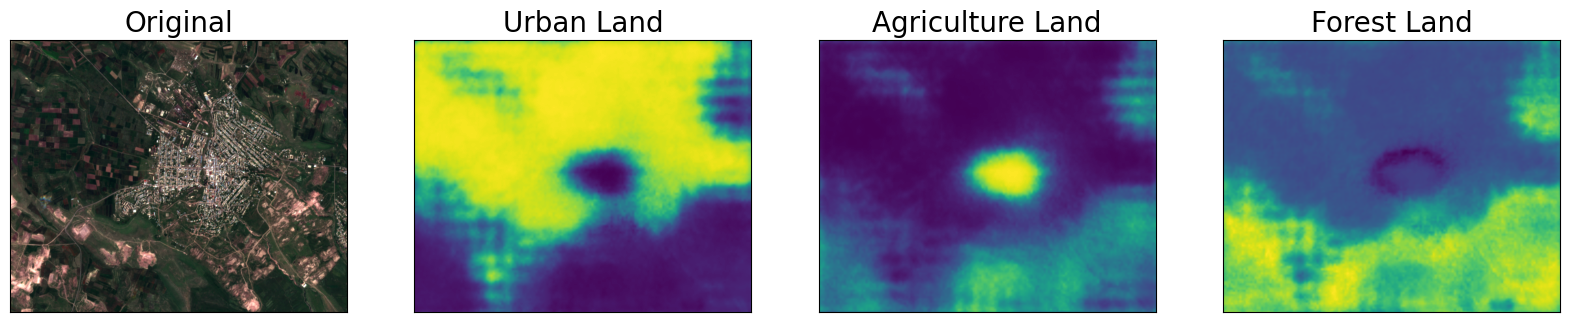

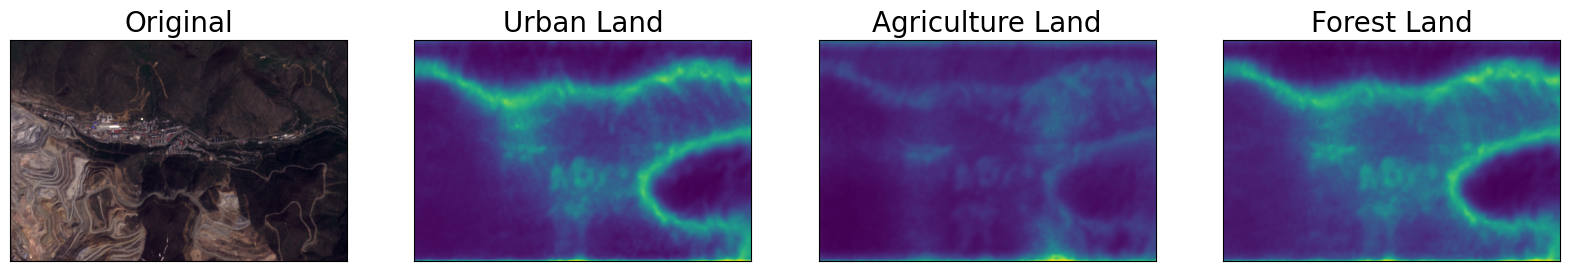

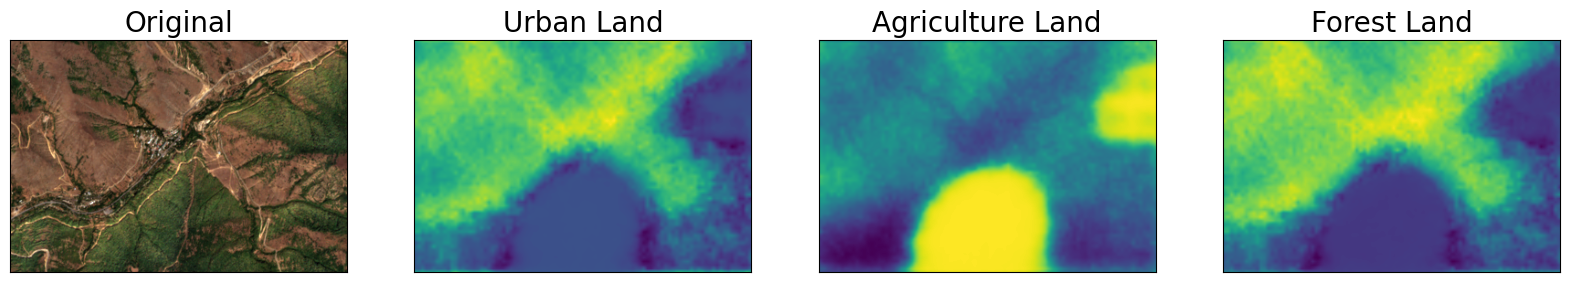

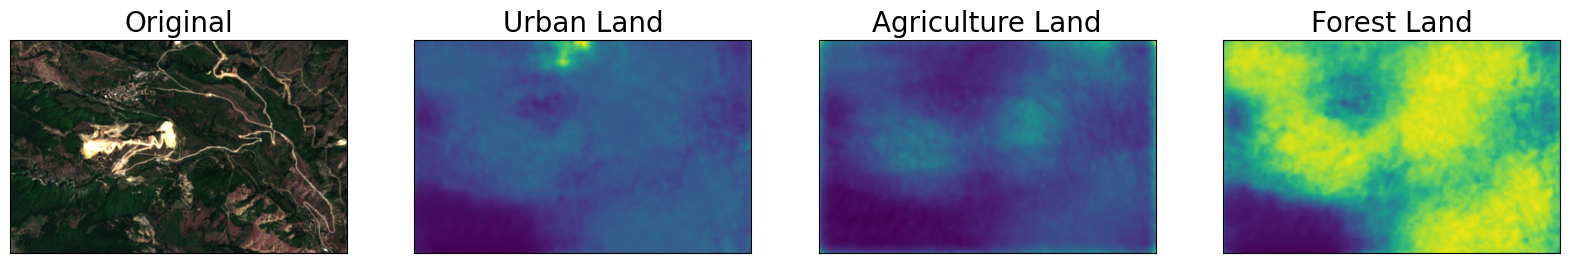

In [56]:
test_folder(
    folder_path="data/test_monuments",
    model=model_kaggle,
    preprocessing_fn=preprocessing_fn,  # from smp.encoders.get_preprocessing_fn(...)
    device="cuda",                      # or "cpu"
    class_names=("urban_land", "agriculture_land", "forest_land"),
    show_soft=True,                     # set True to see per-class probability heatmaps
    save_path='test_predictions.png',
)
